## Libraries

In [244]:
from sqlalchemy import create_engine, Table, Column, Integer,Float, String, MetaData 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Initial connection

In [245]:
with open ('credential.json', 'r') as credentials:
    """ Load credentials from json file """
    credential = json.load(credentials)
    username = credential.get('username')
    password = credential.get('password')
    host = credential.get('host')
    port = credential.get('port')
    database = credential.get('database')
    print('Credentials loaded')


engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{database}')

Credentials loaded


## Extraction

In [246]:
query = 'SELECT * FROM candidates_raw'
data = pd.read_sql_query(query, engine)
data.head(4)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   First Name                 50000 non-null  object
 1   Last Name                  50000 non-null  object
 2   Email                      50000 non-null  object
 3   Application Date           50000 non-null  object
 4   Country                    50000 non-null  object
 5   YOE                        50000 non-null  int64 
 6   Seniority                  50000 non-null  object
 7   Technology                 50000 non-null  object
 8   Code Challenge Score       50000 non-null  int64 
 9   Technical Interview Score  50000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.8+ MB


## Initial cleaning

In [247]:
data.dropna(inplace=True)
data['Application Date'] = pd.to_datetime(data['Application Date'])
print(data.duplicated().sum())
data.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   First Name                 50000 non-null  object        
 1   Last Name                  50000 non-null  object        
 2   Email                      50000 non-null  object        
 3   Application Date           50000 non-null  datetime64[ns]
 4   Country                    50000 non-null  object        
 5   YOE                        50000 non-null  int64         
 6   Seniority                  50000 non-null  object        
 7   Technology                 50000 non-null  object        
 8   Code Challenge Score       50000 non-null  int64         
 9   Technical Interview Score  50000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 3.8+ MB


## EDA

### Reemplazar algunos tipos de datos en algunas columnas para el analisis de correlación

Busco reemplazar los valores de las columnas 'Seniority' y 'Technology' de tipo String a Int para realizar un analisis de correlación, ya que sería interesante ver si influye el seniority y el titulo en la efectividad que tiene el postulado en el puntaje de la prueba.

In [248]:
print(data.nunique())


First Name                    3007
Last Name                      474
Email                        49833
Application Date              1646
Country                        244
YOE                             31
Seniority                        7
Technology                      24
Code Challenge Score            11
Technical Interview Score       11
dtype: int64


In [249]:
print(data['Technology'].unique())
print('--------------------------------')
print(data['Seniority'].unique())

['Data Engineer' 'Client Success' 'QA Manual'
 'Social Media Community Management' 'Adobe Experience Manager' 'Sales'
 'Mulesoft' 'DevOps' 'Development - CMS Backend' 'Salesforce'
 'System Administration' 'Security' 'Game Development'
 'Development - CMS Frontend' 'Security Compliance'
 'Development - Backend' 'Design'
 'Business Analytics / Project Management' 'Development - Frontend'
 'Development - FullStack' 'Business Intelligence'
 'Database Administration' 'QA Automation' 'Technical Writing']
--------------------------------
['Intern' 'Mid-Level' 'Trainee' 'Junior' 'Lead' 'Architect' 'Senior']


In [250]:
data['Seniority_INT'] = data['Seniority'].replace({'Intern':1, 'Mid-Level':2, 'Trainee':3, 'Junior':4, 'Lead':5, 'Architect':6, 'Senior':7})
data['Technology_INT'] = data['Technology'].replace(
    {
  "Data Engineer": 1,
  "Client Success": 2,
  "QA Manual": 3,
  "Social Media Community Management": 4,
  "Adobe Experience Manager": 5,
  "Sales": 6,
  "Mulesoft": 7,
  "DevOps": 8,
  "Development - CMS Backend": 9,
  "Salesforce": 10,
  "System Administration": 11,
  "Security": 12,
  "Game Development": 13,
  "Development - CMS Frontend": 14,
  "Security Compliance": 15,
  "Development - Backend": 16,
  "Design": 17,
  "Business Analytics / Project Management": 18,
  "Development - Frontend": 19,
  "Development - FullStack": 20,
  "Business Intelligence": 21,
  "Database Administration": 22,
  "QA Automation": 23,
  "Technical Writing": 24
}
)


C:\Users\juanr\AppData\Local\Temp\ipykernel_24736\2222633928.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Seniority_INT'] = data['Seniority'].replace({'Intern':1, 'Mid-Level':2, 'Trainee':3, 'Junior':4, 'Lead':5, 'Architect':6, 'Senior':7})
C:\Users\juanr\AppData\Local\Temp\ipykernel_24736\2222633928.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Technology_INT'] = data['Technology'].replace(


### Agregar la columna is_hired

In [251]:
#Este código se me ocurrió pero no es para nada optimo, lo dejo comentado para que veas que se me ocurrió.

#for i in data['Technical Interview Score']:
#    for e in data['Code Challenge Score']:
#        if i >= 7 and e >= 7:
#            data['is_hired'] = 'Hired'
#        else:
#            data['is_hired'] = 'Not Hired'

In [252]:
data['is_hired'] = np.where((data['Technical Interview Score'] >= 7) & (data['Code Challenge Score'] >= 7), 'Hired', 'Not Hired')
data['is_hired_INT'] = data['is_hired'].replace({'Hired':1, 'Not Hired':0})

C:\Users\juanr\AppData\Local\Temp\ipykernel_24736\3760771110.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_hired_INT'] = data['is_hired'].replace({'Hired':1, 'Not Hired':0})


In [253]:
data.head(20)

,First Name,Last Name,Email,Application Date,Country,YOE,Seniority,Technology,Code Challenge Score,Technical Interview Score,Seniority_INT,Technology_INT,is_hired,is_hired_INT
0,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3,1,1,Not Hired,0
1,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10,1,1,Not Hired,0
2,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9,2,2,Hired,1
3,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1,3,3,Not Hired,0
4,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7,2,4,Hired,1
5,Alec,Abbott,juanita_hansen@gmail.com,2019-08-17,Zimbabwe,8,Junior,Adobe Experience Manager,2,9,4,5,Not Hired,0
6,Allison,Jacobs,alba_rolfson27@yahoo.com,2018-05-18,Wallis and Futuna,19,Trainee,Sales,2,9,3,6,Not Hired,0
7,Nya,Skiles,madisen.zulauf@gmail.com,2021-12-09,Myanmar,1,Lead,Mulesoft,2,5,5,7,Not Hired,0
8,Mose,Lakin,dale_murazik@hotmail.com,2018-03-13,Italy,18,Lead,Social Media Community Management,7,10,5,4,Hired,1
9,Terrance,Zieme,dustin31@hotmail.com,2022-04-08,Timor-Leste,25,Lead,DevOps,2,0,5,8,Not Hired,0


In [254]:
data.describe()

,Application Date,YOE,Code Challenge Score,Technical Interview Score,Seniority_INT,Technology_INT,is_hired_INT
count,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2020-04-03 23:04:14.592000,15.286980,4.996400,5.003880,3.979040,12.311220,0.133960
min,2018-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,2019-02-17 00:00:00,8.000000,2.000000,2.000000,2.000000,7.000000,0.000000
50%,2020-04-06 00:00:00,15.000000,5.000000,5.000000,4.000000,12.000000,0.000000
75%,2021-05-21 00:00:00,23.000000,8.000000,8.000000,6.000000,18.000000,0.000000
max,2022-07-04 00:00:00,30.000000,10.000000,10.000000,7.000000,24.000000,1.000000
std,NaN,8.830652,3.166896,3.165082,2.001949,6.713913,0.340613


### Charts

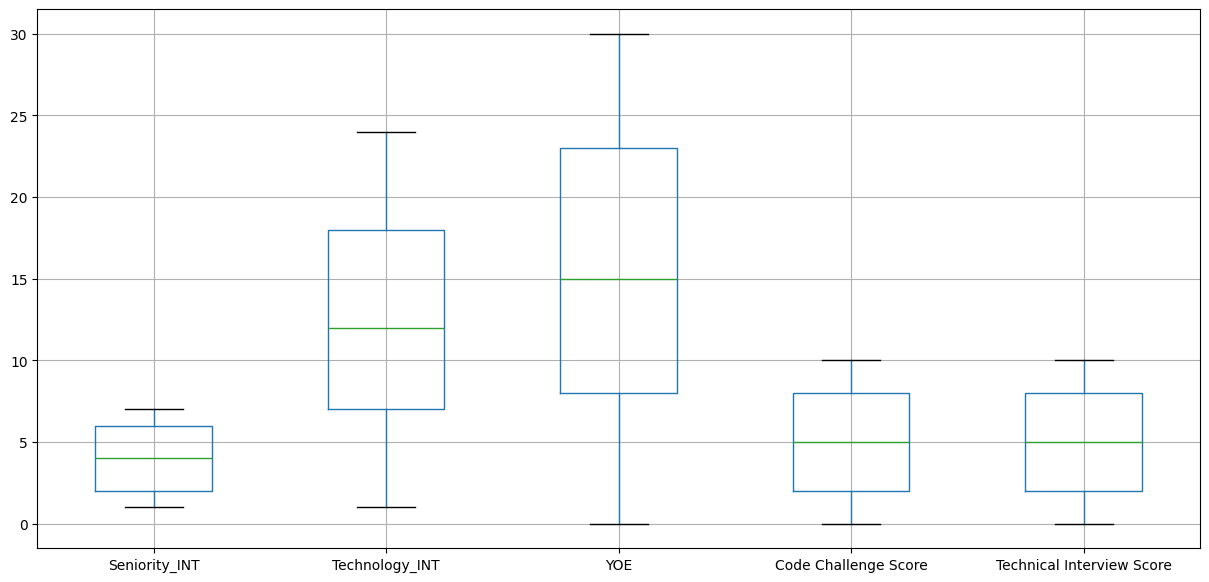

In [255]:
fig = plt.figure(figsize =(15, 7))
boxplot = data.boxplot(column=['Seniority_INT', 'Technology_INT', 'YOE', 'Code Challenge Score', 'Technical Interview Score'])
plt.show()

No existen valores atipicos que puedan interferir de manera negativa en la visualización de datos con dashboard, podríamos irnos con los datos previamente limpios

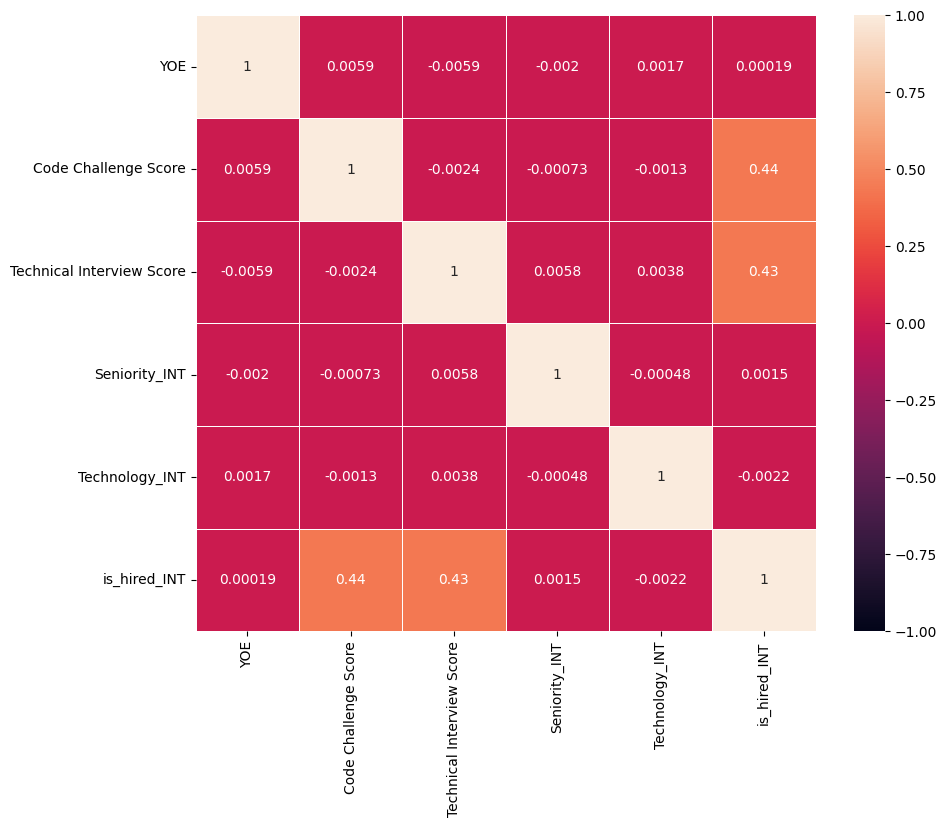

In [256]:
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True, linewidth=.5, vmin=-1, vmax=1)
plt.show()

Como podemos observar, no existe una correlación significativa entre las variables de nuestro dataframe, salvo la correlación entre Code Challenge Score, Technical Interview Score y is_hired_INT, que es un poco redundante, pues los que obtienen puntajes mayor o igual a 7 de las dos primeras variables anteriores es contratado, sin importar si sacó más puntaje que eso. Podríamos eliminar Seniority_INT, Technology_INT y is_hired_INT, ya que fueron variables temporales sin éxito para el analisis de correlación

In [257]:
data.drop(columns=['Seniority_INT', 'Technology_INT', 'is_hired_INT'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   First Name                 50000 non-null  object        
 1   Last Name                  50000 non-null  object        
 2   Email                      50000 non-null  object        
 3   Application Date           50000 non-null  datetime64[ns]
 4   Country                    50000 non-null  object        
 5   YOE                        50000 non-null  int64         
 6   Seniority                  50000 non-null  object        
 7   Technology                 50000 non-null  object        
 8   Code Challenge Score       50000 non-null  int64         
 9   Technical Interview Score  50000 non-null  int64         
 10  is_hired                   50000 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 4.2+ MB


## Load

In [258]:
# Create table in the database
metadata = MetaData()

def infer_sqlalchemy_type(dtype):
    """ Map pandas dtype to SQLAlchemy's types """
    if "int" in dtype.name:
        return Integer
    elif "float" in dtype.name:
        return Float
    elif "object" in dtype.name:
        return String(255)
    else:
        return String(255)

columns = [Column(name, infer_sqlalchemy_type(dtype)) for name, dtype in data.dtypes.items()]
table = Table('candidates_clean', metadata, *columns)

table.create(engine)

In [259]:
try:
    data.to_sql('candidates_clean', engine, if_exists='append', index=False)
except Exception as e:
    print(e)
finally:
    print('Data cleaned inserted :D')

Data inserted
